In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score
import itertools
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, log_loss
import xgboost as xgb
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Load the training and test datasets
train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]


In [4]:
train = pd.read_csv(train_url, header=None, names=col_names)
test = pd.read_csv(test_url, header=None, names=col_names)
print('Dimensions of the Training set:',train.shape)
print('Dimensions of the Test set:',test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [5]:

# Label adjustment
train["label"] = train["label"].apply(lambda x: "normal" if x == "normal" else "anomalous")
test["label"] = test["label"].apply(lambda x: "normal" if x == "normal" else "anomalous")
# Checking the distribution after the change
print(train["label"].value_counts())
print()
print(test["label"].value_counts())

label
normal       67343
anomalous    58630
Name: count, dtype: int64

label
anomalous    12833
normal        9711
Name: count, dtype: int64


In [6]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 9


In [7]:
print(f"Number of duplicate rows: {test.duplicated().sum()}")

Number of duplicate rows: 3


In [8]:
# Removing duplicate rows
test.drop_duplicates(inplace=True)

# Check the shape of the dataset after removing duplicates
print(f"New shape of the dataset: {test.shape}")

New shape of the dataset: (22541, 42)


In [9]:
# Removing duplicate rows
train.drop_duplicates(inplace=True)

# Check the shape of the dataset after removing duplicates
print(f"New shape of the dataset: {train.shape}")

New shape of the dataset: (125964, 42)


In [10]:
import pandas as pd

# Assuming df is your DataFrame
def check_constant_columns(test):
    constant_columns = [col for col in test.columns if test[col].nunique() == 1]
    return constant_columns

# Example usage
constant_cols = check_constant_columns(test)
if constant_cols:
    print(f"Columns with the same value across all rows: {constant_cols}")
else:
    print("No columns have the same value across all rows.")

Columns with the same value across all rows: ['num_outbound_cmds']


In [11]:
#Dropping a column because every value is 0 
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [12]:
# Apply LabelEncoding
def LabelEncoding(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])

LabelEncoding(train)
LabelEncoding(test)



In [13]:
X_train = train.drop(["label"], axis=1)
y_train = train["label"]
X_test = test.drop(["label"], axis=1)
y_test = test["label"]

In [14]:
from sklearn.model_selection import GridSearchCV #cross validation
import xgboost as xgb

# xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=42, early_stopping_rounds=10, 
#             eval_metric='aucpr')

# xgb_clf.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

# Range of n_estimators values to evaluate
n_estimators_range = range(10, 110, 10)  # 10, 20, ..., 100

# Lists to store training and validation accuracies
train_accuracies = []
validation_accuracies = []
train_losses = []
validation_losses = []
# Loop through each n_estimators value
for n_estimators in n_estimators_range:
    # Initialize the XGBoost model with current n_estimators
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=42, 
                                n_estimators=n_estimators, early_stopping_rounds=10, 
                                eval_metric='aucpr')
    
    # Fit the model on training data with validation set for early stopping
    xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)


     # Training accuracy
    y_train_preds = xgb_clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_preds)
    train_accuracies.append(train_accuracy)
    
    # Validation accuracy
    y_test_preds = xgb_clf.predict(X_test)
    validation_accuracy = accuracy_score(y_test, y_test_preds)
    validation_accuracies.append(validation_accuracy)

In [15]:
# Convert accuracies to losses (1 - accuracy)
train_losses = [1 - acc for acc in train_accuracies]
validation_losses = [1 - acc for acc in validation_accuracies]

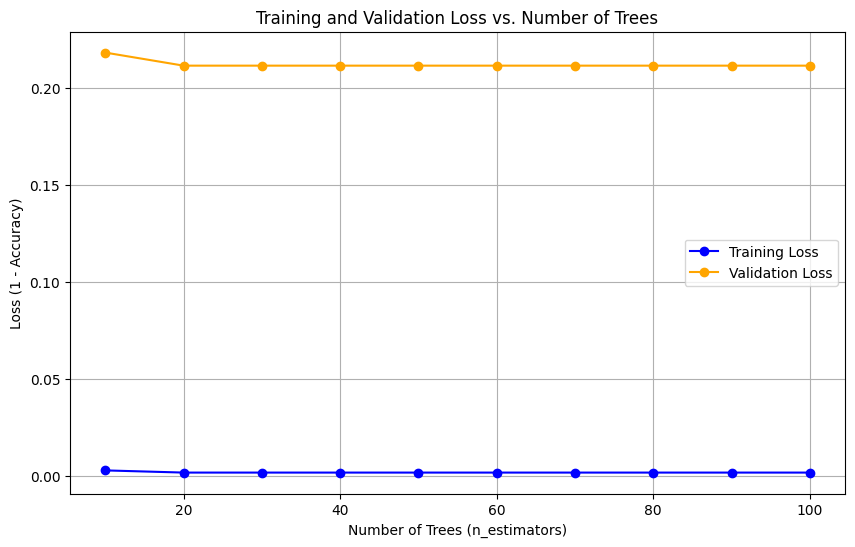

In [16]:
# # Plot the Log Loss Graph
# plt.figure(figsize=(10, 6))
# plt.plot(n_estimators_range, train_losses, label='Training Log Loss', marker='o', color='blue')
# plt.plot(n_estimators_range, validation_losses, label='Validation Log Loss', marker='o', color='orange')
# plt.xlabel('Number of Trees (n_estimators)')
# plt.ylabel('Log Loss')
# plt.title('Training and Validation Log Loss vs. Number of Trees')
# plt.legend()
# plt.grid(True)
# plt.show()
# Plot the Loss Graph
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_losses, label='Training Loss', marker='o', color='blue')
plt.plot(n_estimators_range, validation_losses, label='Validation Loss', marker='o', color='orange')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Loss (1 - Accuracy)')
plt.title('Training and Validation Loss vs. Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

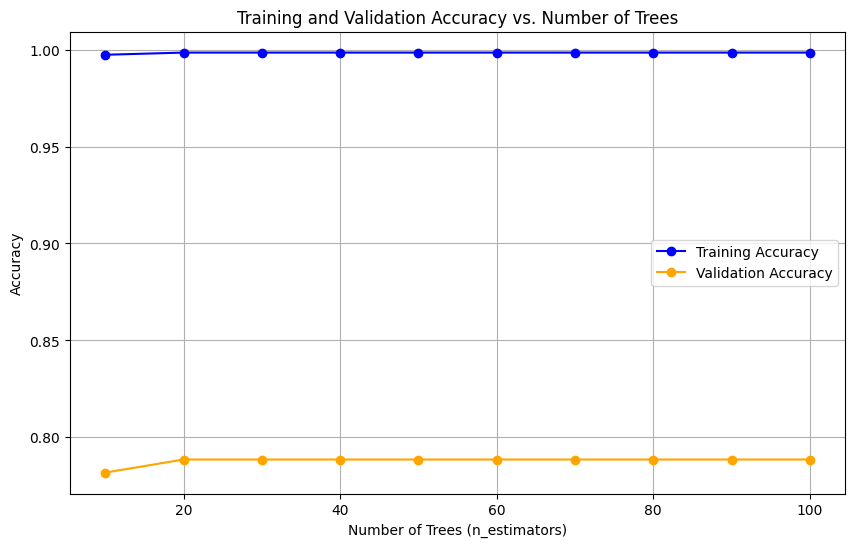

In [17]:
# # Plot the Accuracy Graph
# plt.figure(figsize=(10, 6))
# plt.plot(n_estimators_range, train_accuracies, label='Training Accuracy', marker='o', color='blue')
# plt.plot(n_estimators_range, validation_accuracies, label='Validation Accuracy', marker='o', color='orange')
# plt.xlabel('Number of Trees (n_estimators)')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy vs. Number of Trees')
# plt.legend()
# plt.grid(True)
# plt.show()
# Plot the Accuracy Graph
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracies, label='Training Accuracy', marker='o', color='blue')
plt.plot(n_estimators_range, validation_accuracies, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Predict and evaluate final model
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 78.85%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.65      0.78     12830
           1       0.68      0.97      0.80      9711

    accuracy                           0.79     22541
   macro avg       0.82      0.81      0.79     22541
weighted avg       0.84      0.79      0.79     22541

